# 0.0. Imports

## 0.1. Helper Functions

In [1]:
# !pip install inflection
# !pip install boruta
# !pip install xgboost

In [131]:
from IPython.display import HTML
from IPython.display import Image

import requests

from sklearn.linear_model import LinearRegression, Lasso

from joblib import dump
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import numpy as np
import inflection
import math

from boruta import BorutaPy
import datetime

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame({'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                         'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                         'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[model_name] )

In [6]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    v = np.sqrt(chi2corr/n / (min(kcorr-1, rcorr-1)))

    return v

In [7]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

In [8]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

In [9]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
  
    return pd.DataFrame({"MAE": mae,
                         "MAPE": mape,
                         "RMSE": rmse}, index=[model_name])

## 0.2. Loading Data

In [10]:
df_sales_raw = pd.read_csv("../databases/train.csv", low_memory=False)
df_store_raw = pd.read_csv("../databases/store.csv", low_memory=False)

In [11]:
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
731023,369,6,2013-09-14,7239,692,1,0,0,0,d,c,5870.0,4.0,2014.0,0,NaN,NaN,NaN


# 1.0. Descrição dos Dados

In [12]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [13]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

In [14]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [15]:
print("Number of Rows: {}".format(df1.shape[0]))
print("NUmber of Cols: {}".format(df1.shape[1]))

Number of Rows: 1017209
NUmber of Cols: 18


## 1.3. Data Types

In [16]:
df1['date'] = pd.to_datetime(df1["date"])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [17]:
df1.isna().mean()

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## 1.5. Fillout NA 

In [18]:
# competition_distance
df1["competition_distance"] = df1["competition_distance"].fillna(200000.0)

In [19]:
# competition_open_since_month
df1.competition_open_since_month = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

In [20]:
# competition_open_since_year
df1.competition_open_since_year = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)

In [21]:
# promo2_since_week
df1["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis=1) 

In [22]:
# promo2_since_year
df1["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis=1)

In [23]:
# promo_interval
month_map = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True)
df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)

## 1.6. Change Data Types

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [25]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

## 1.7. Descriptive Statistical 

In [26]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

### 1.7.1 Numerical Attributes

In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

In [28]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

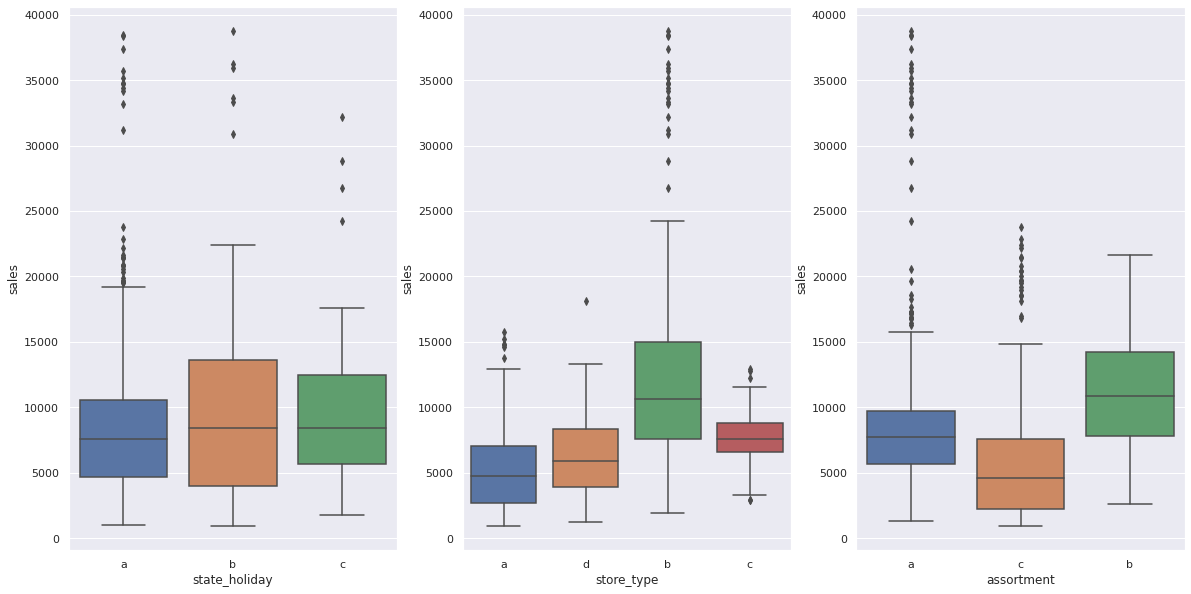

In [30]:
sns.set_style()
plt.figure(figsize=(20, 10))

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x="assortment", y="sales", data=aux1)

# 2.0. Feature Engineering

In [31]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

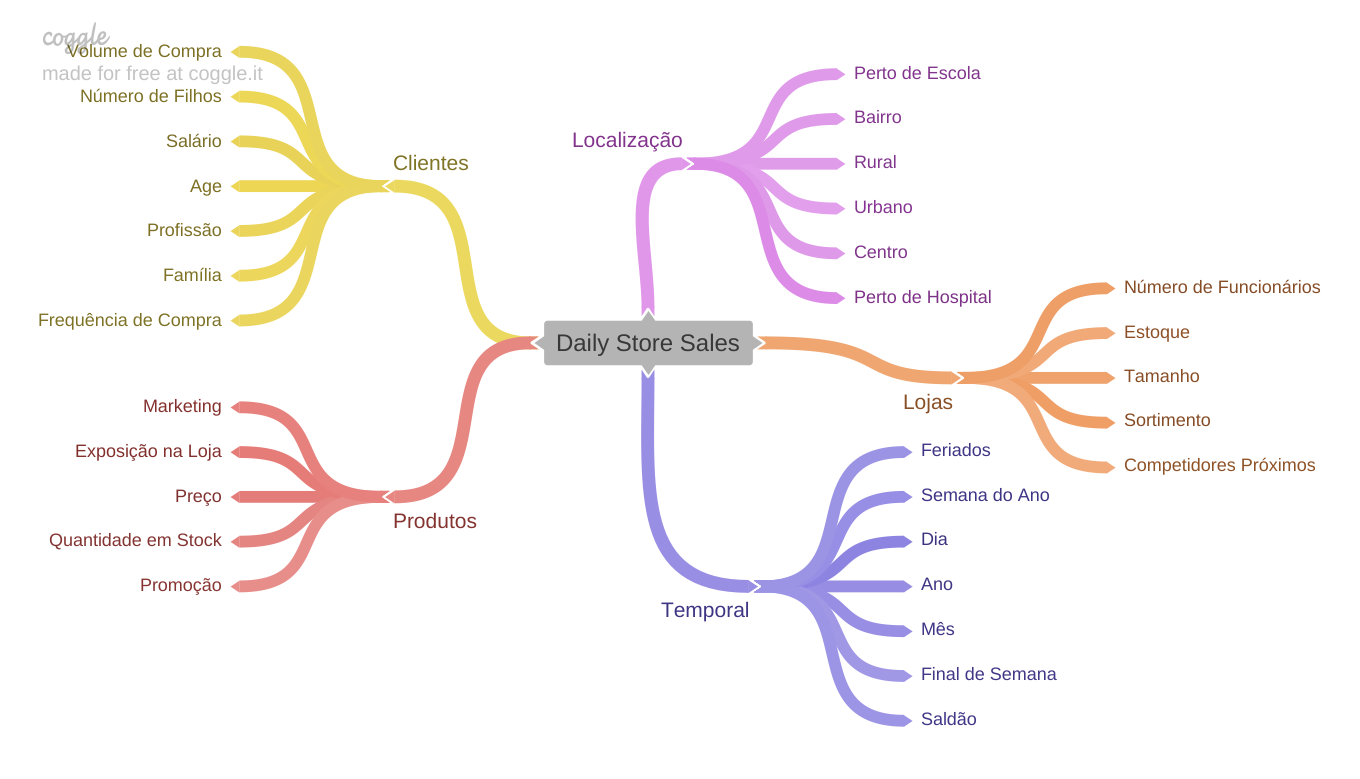

In [32]:
Image("../images/Mind_Map_Hipoteses.png")

## 2.2 Creating Hypotheses

### 2.2.1 Sales' Hypotheses

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**5.** Lojas com maior sortemente deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Product's Hypotheses

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que têm preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Time's Hypotheses

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo sementre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Hypotheses' Final List

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo sementre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [33]:
# year
df2["year"] = df2["date"].dt.year

In [34]:
# month
df2["month"] = df2["date"].dt.month

In [35]:
# day
df2["day"] = df2["date"].dt.day

In [36]:
# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week

In [37]:
# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

In [38]:
# competition since
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis=1)

df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

In [39]:
# promo sence
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)

df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w") - datetime.timedelta(days=7))

df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)

In [40]:
# assortment
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")

In [41]:
# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")

In [42]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtering Variables

In [43]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [44]:
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2 Filtering Columns

In [45]:
df3 = df3.drop(["customers", "open", "promo_interval", "month_map"], axis=1)

# 4.0 Exploratory Data Analysis

In [46]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

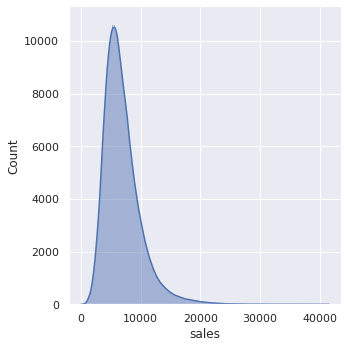

In [47]:
sns.displot(df4["sales"], kde=True);

### 4.1.2 Numerical Variable

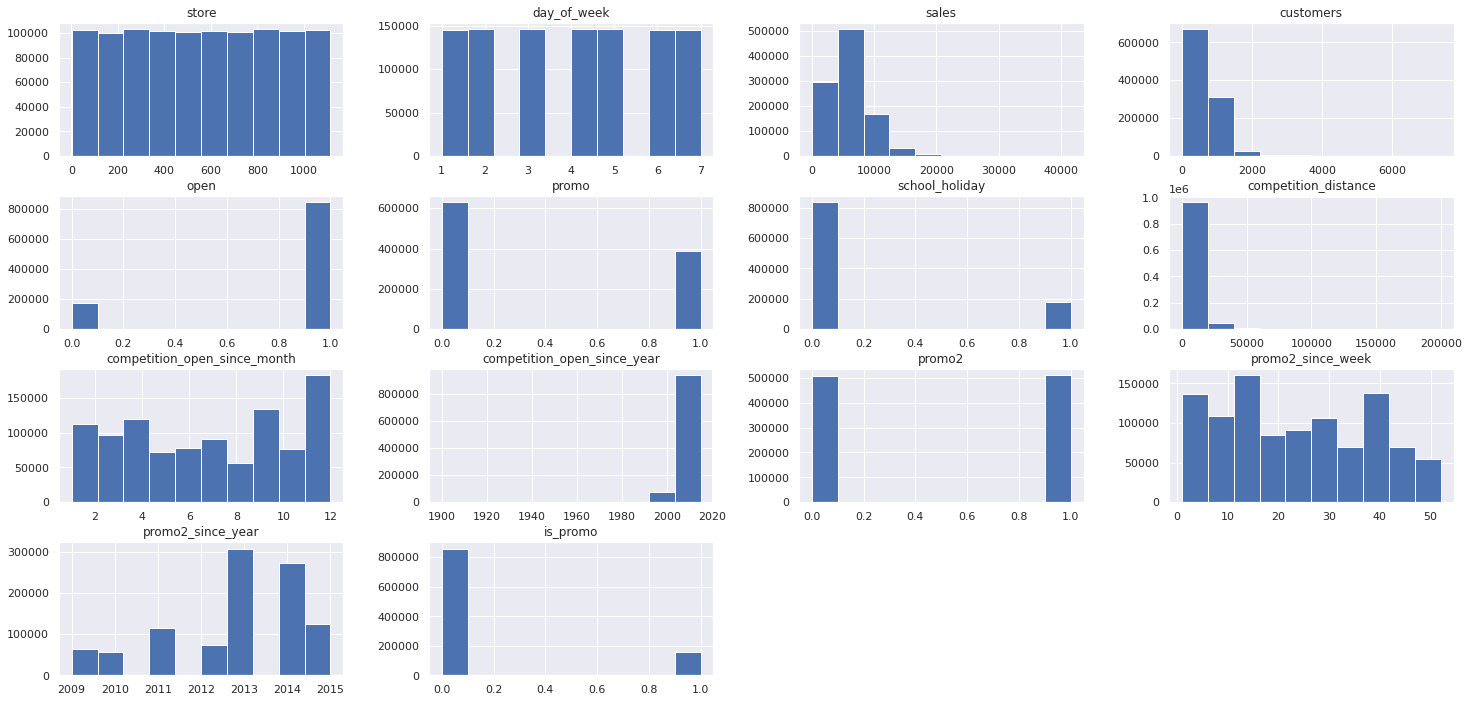

In [48]:
num_attributes.hist();

### 4.1.3 Categorical Variable

/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wi

<AxesSubplot:xlabel='sales', ylabel='Density'>

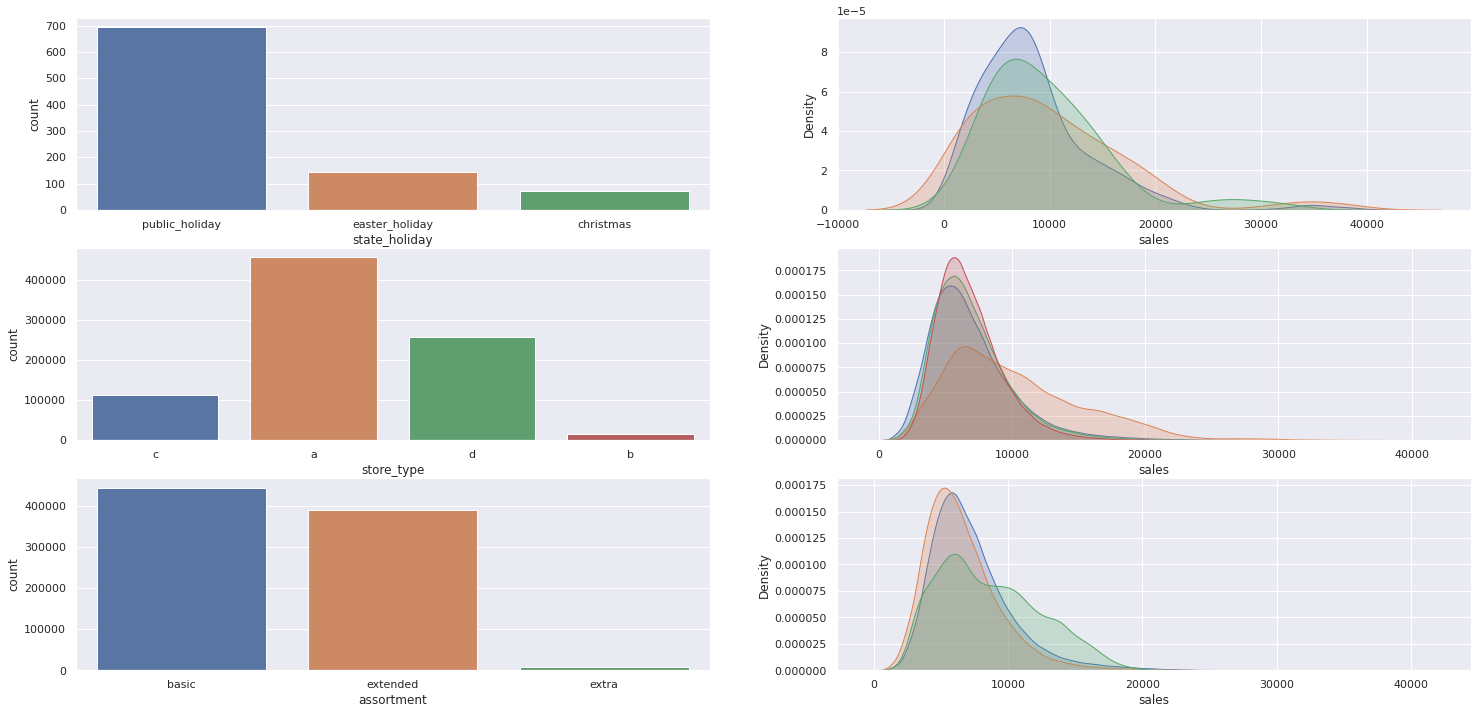

In [49]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(a["state_holiday"])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4["store_type"])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", shade=True)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", shade=True)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="b", shade=True)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="b", shade=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df4["assortment"])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True)
sns.kdeplot(df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True)

## 4.2 Bivariate Analysis

### H1 Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.

<AxesSubplot:xlabel='year_week'>

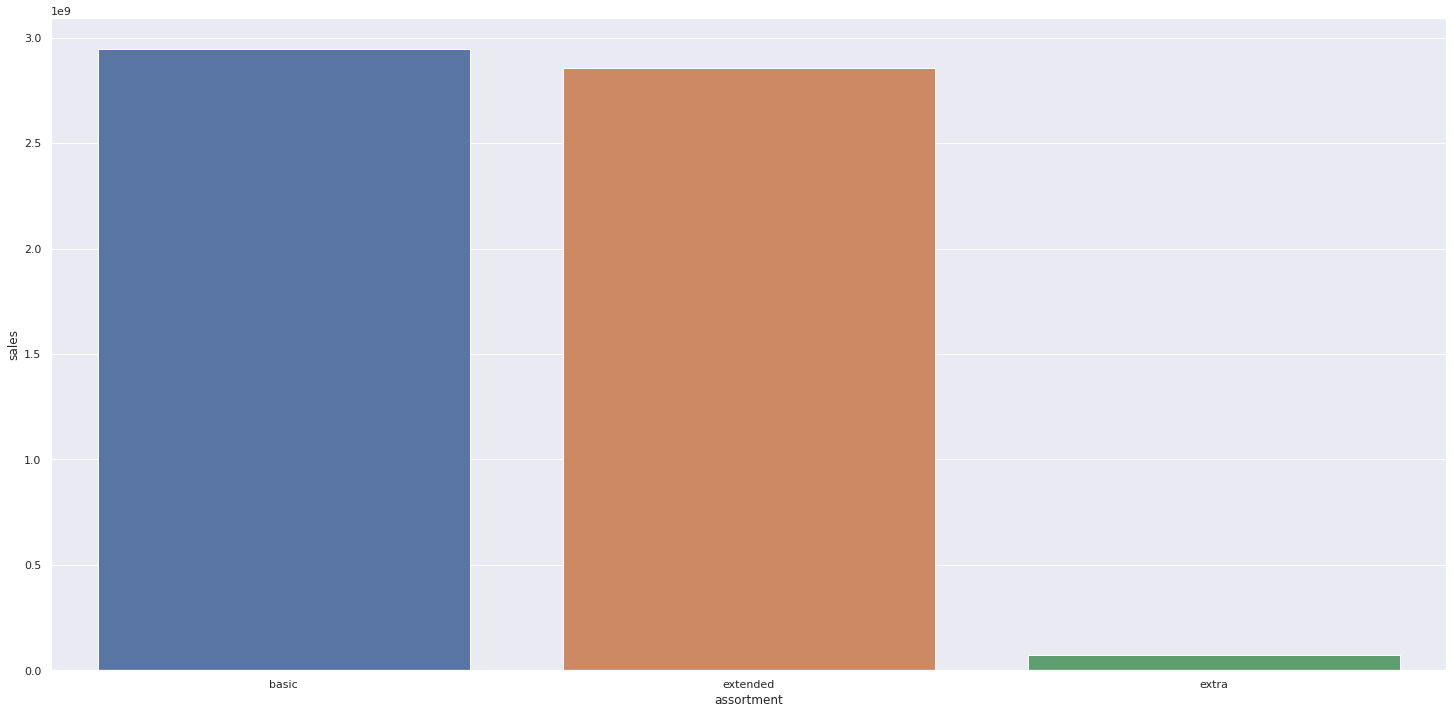

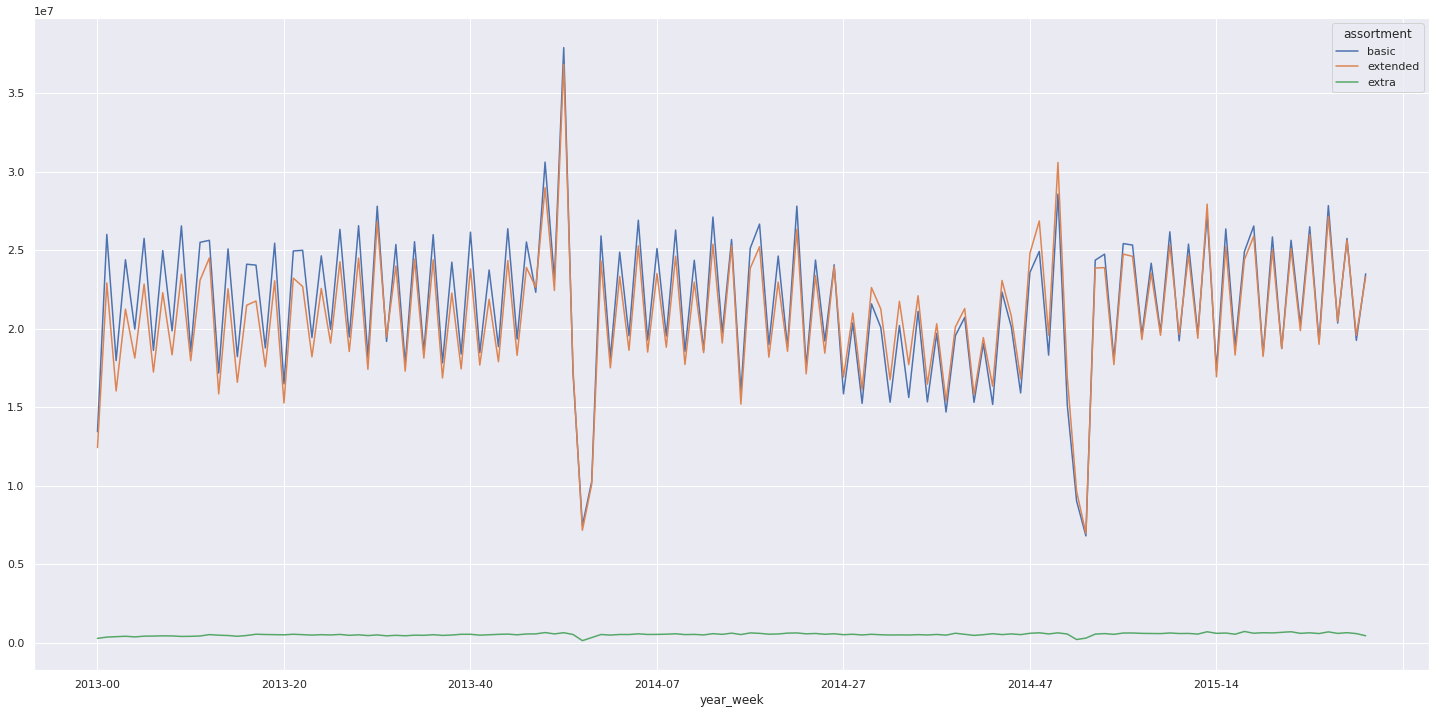

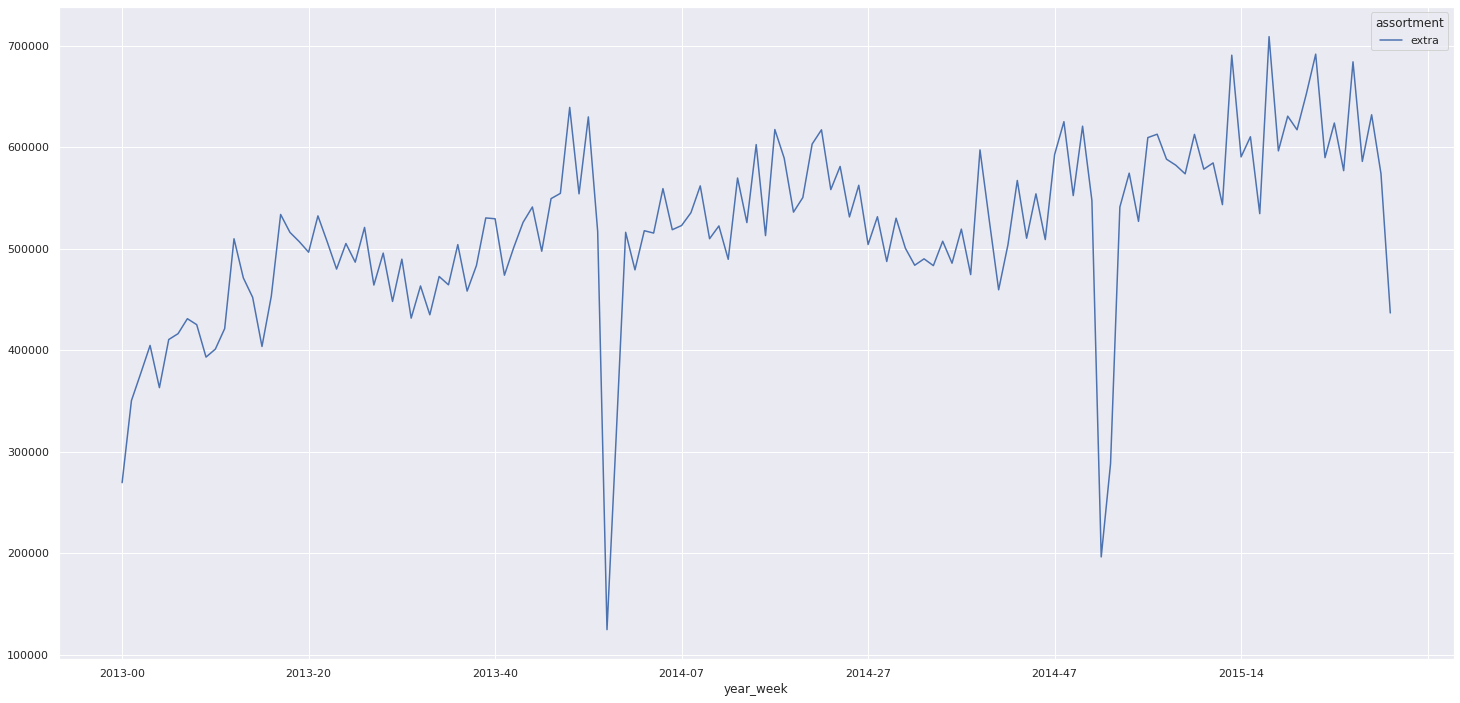

In [50]:
aux1 = df4[["assortment", "sales"]].groupby("assortment").sum().reset_index()
sns.barplot(x="assortment", y="sales", data=aux1);

aux2 = df4[["year_week", "assortment", "sales"]].groupby(["year_week", "assortment"]).sum().reset_index()
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

aux3 = aux2[aux2["assortment"] == "extra"]
aux3.pivot(index="year_week", columns="assortment", values="sales").plot()

### H2 Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vedem MAIS

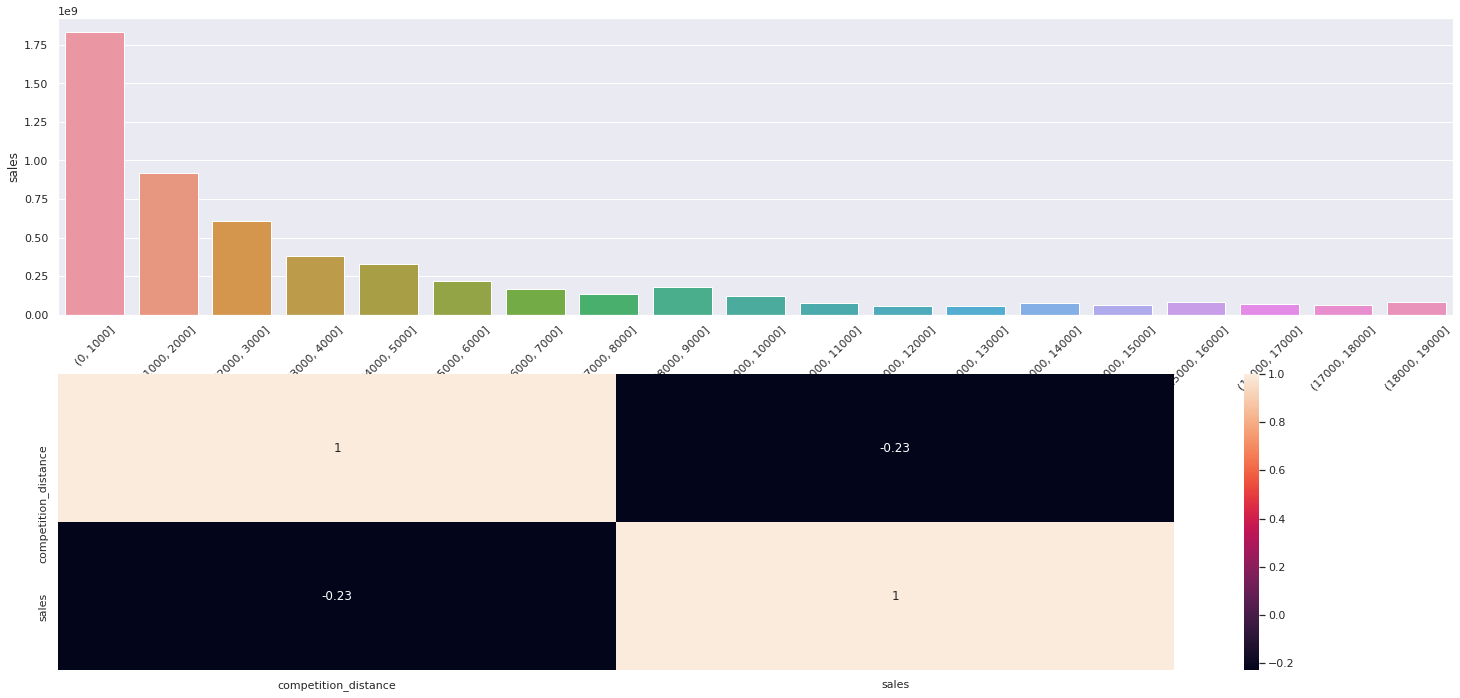

In [51]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()

plt.subplot(2, 1, 1)
#sns.barplot(x="competition_distance", y="sales", data=aux1);
sns.barplot(x="competition_distance_binned", y="sales", data=aux2);
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

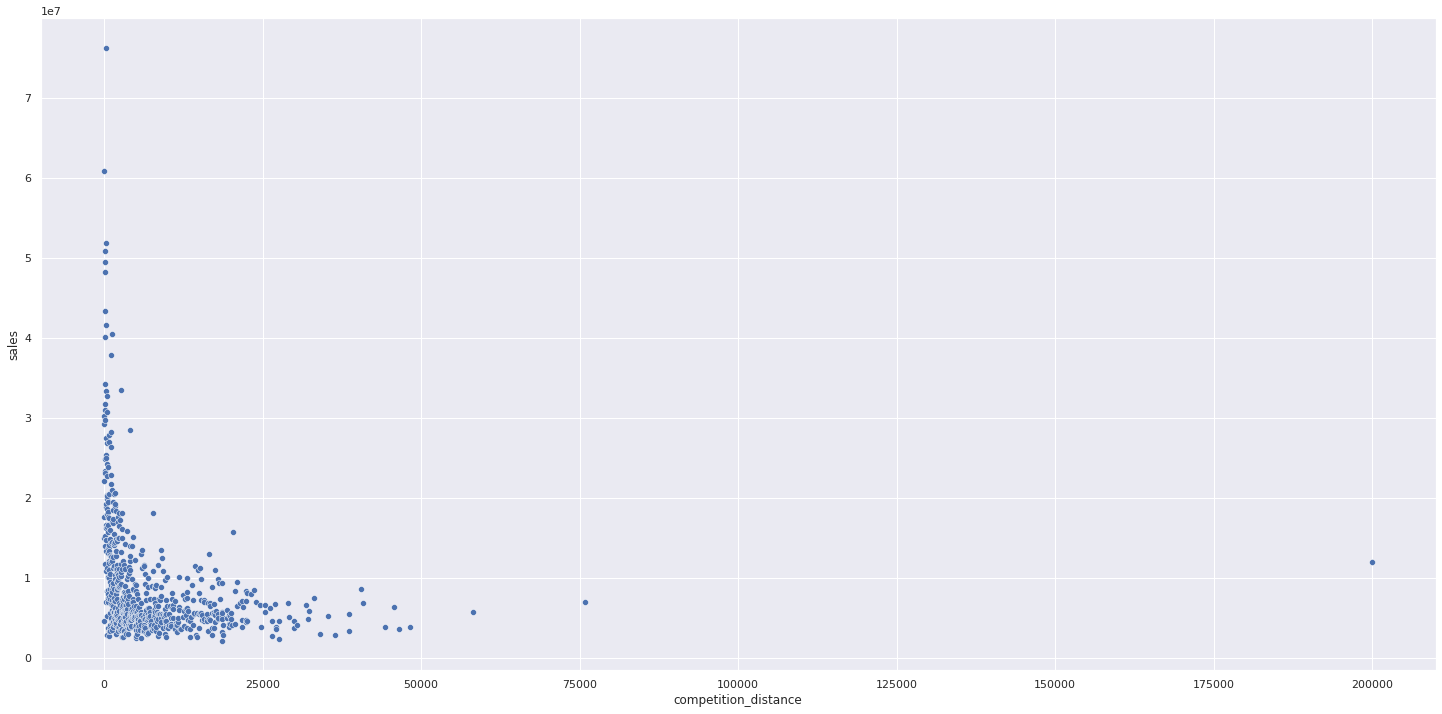

In [52]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

sns.scatterplot(x="competition_distance", y="sales", data=aux1);

### H3 Lojas com maior sortimento deveriam vender mais.

**FALSA** porque lojas com competidores à mais tempo vendem menos.

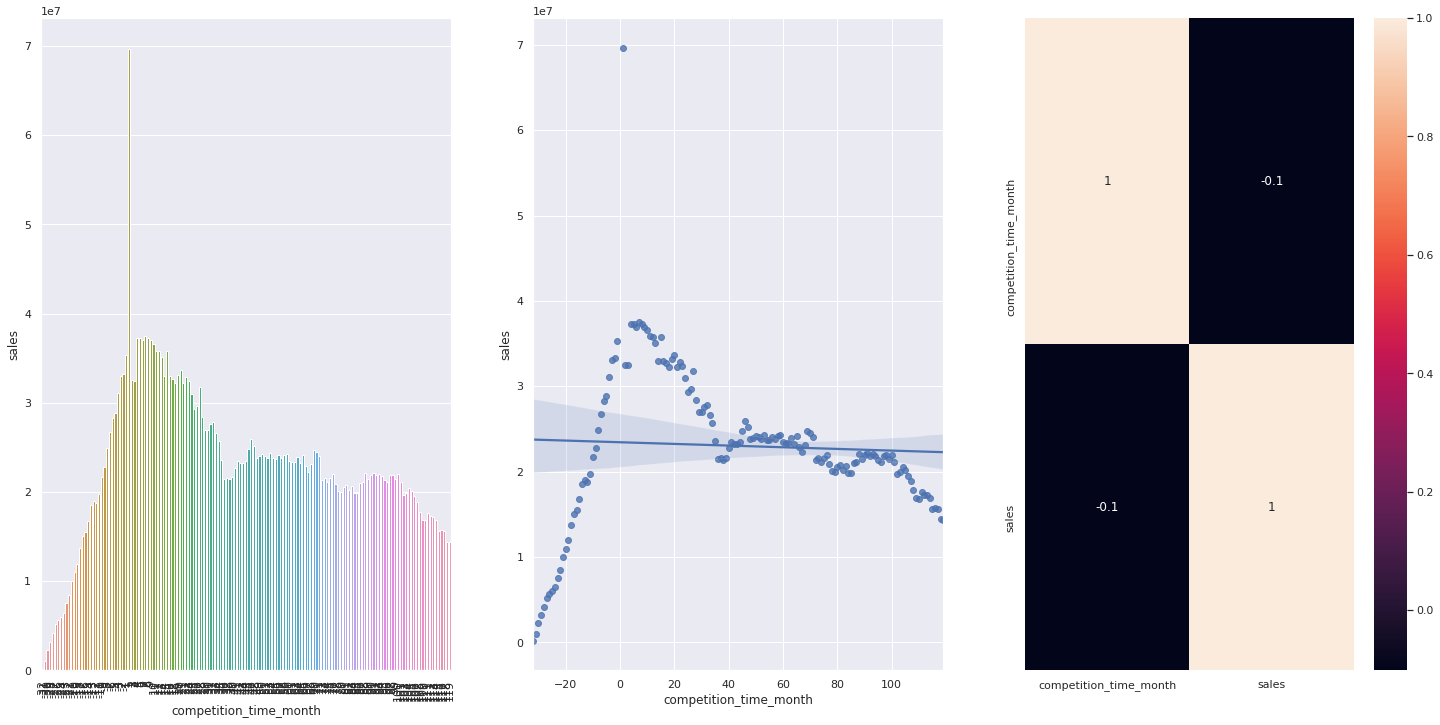

In [53]:
plt.subplot(1, 3, 1)
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").sum().reset_index()
aux2 = aux1[(aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

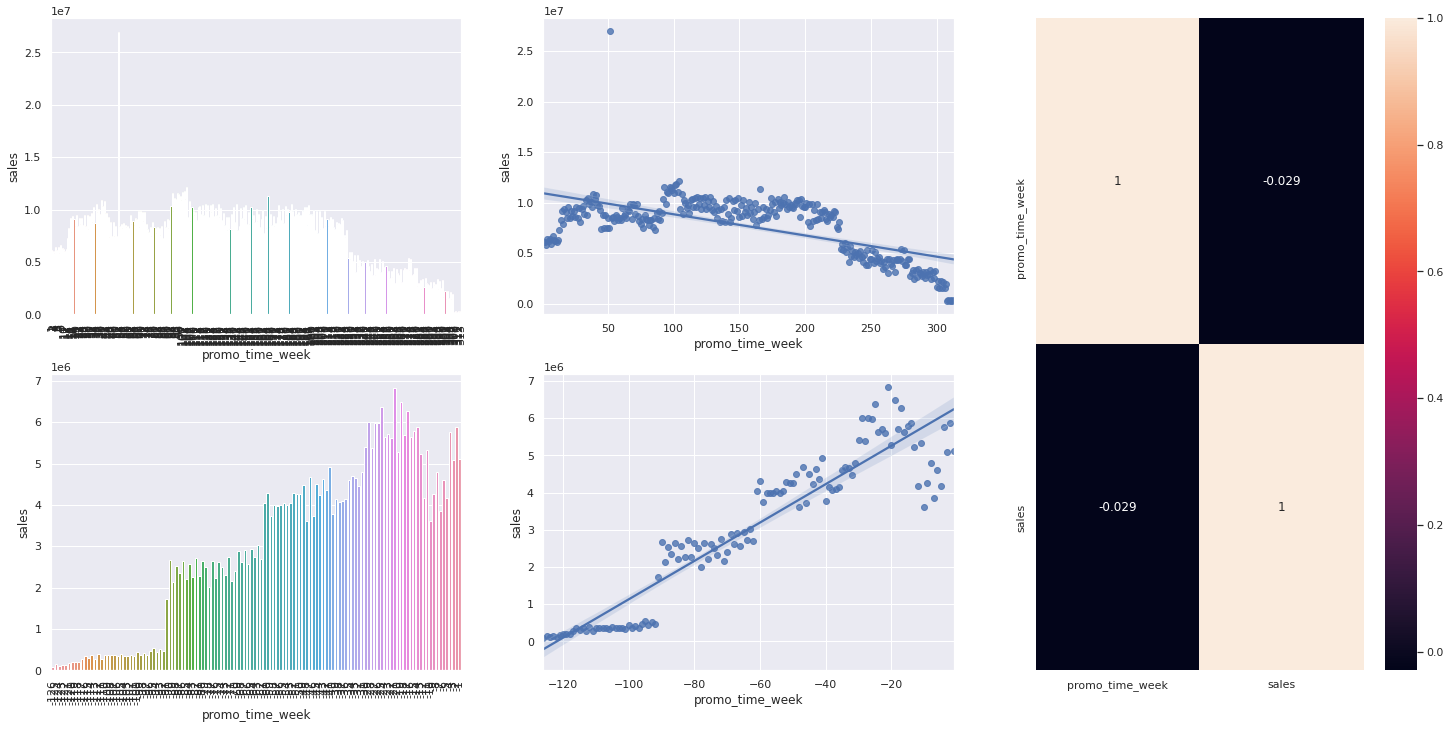

In [54]:
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1["promo_time_week"] > 0] # promo extendida
sns.barplot(x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1["promo_time_week"] < 0] # promo regular
sns.barplot(x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [55]:
df4[["promo", "promo2", "sales"]].groupby(["promo", "promo2"]).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

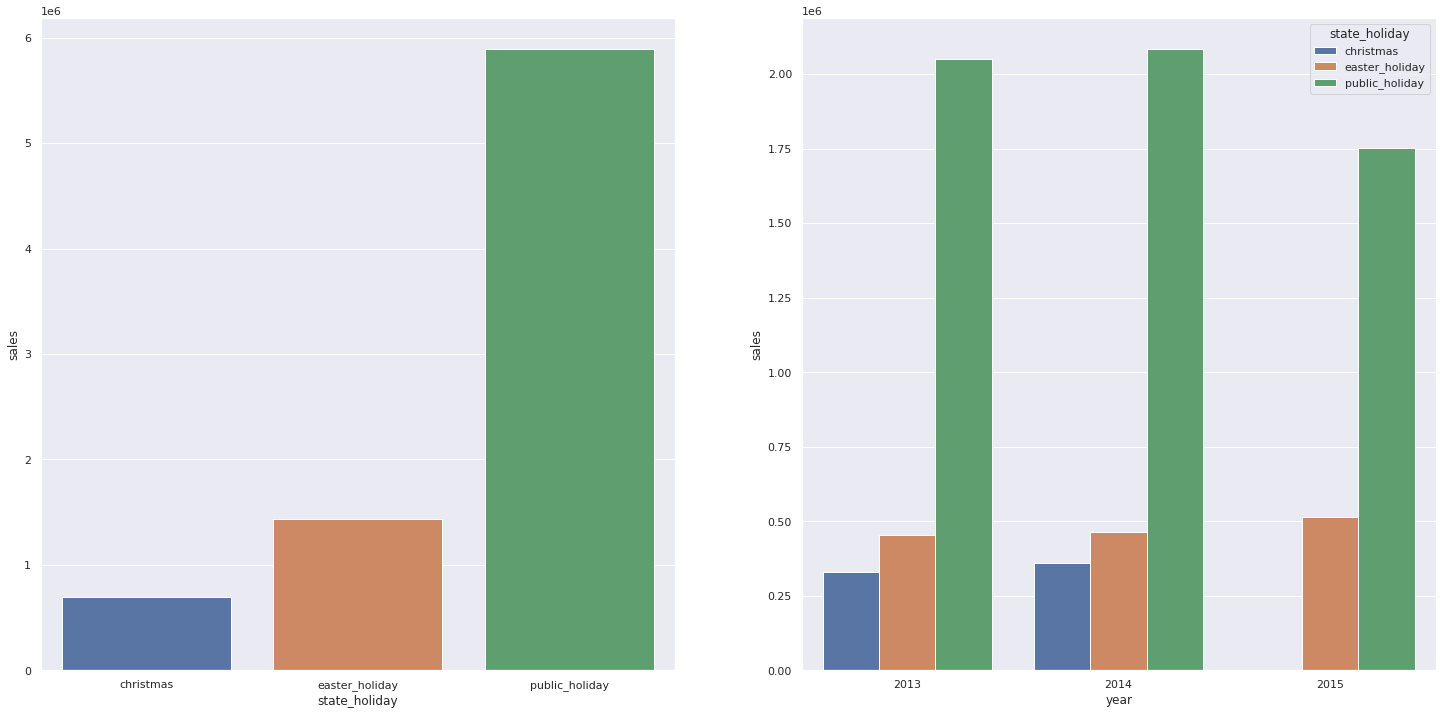

In [56]:
aux = df4[df4["state_holiday"] != "regular_day"]

plt.subplot(1, 2, 1)
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).sum().reset_index()
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos.

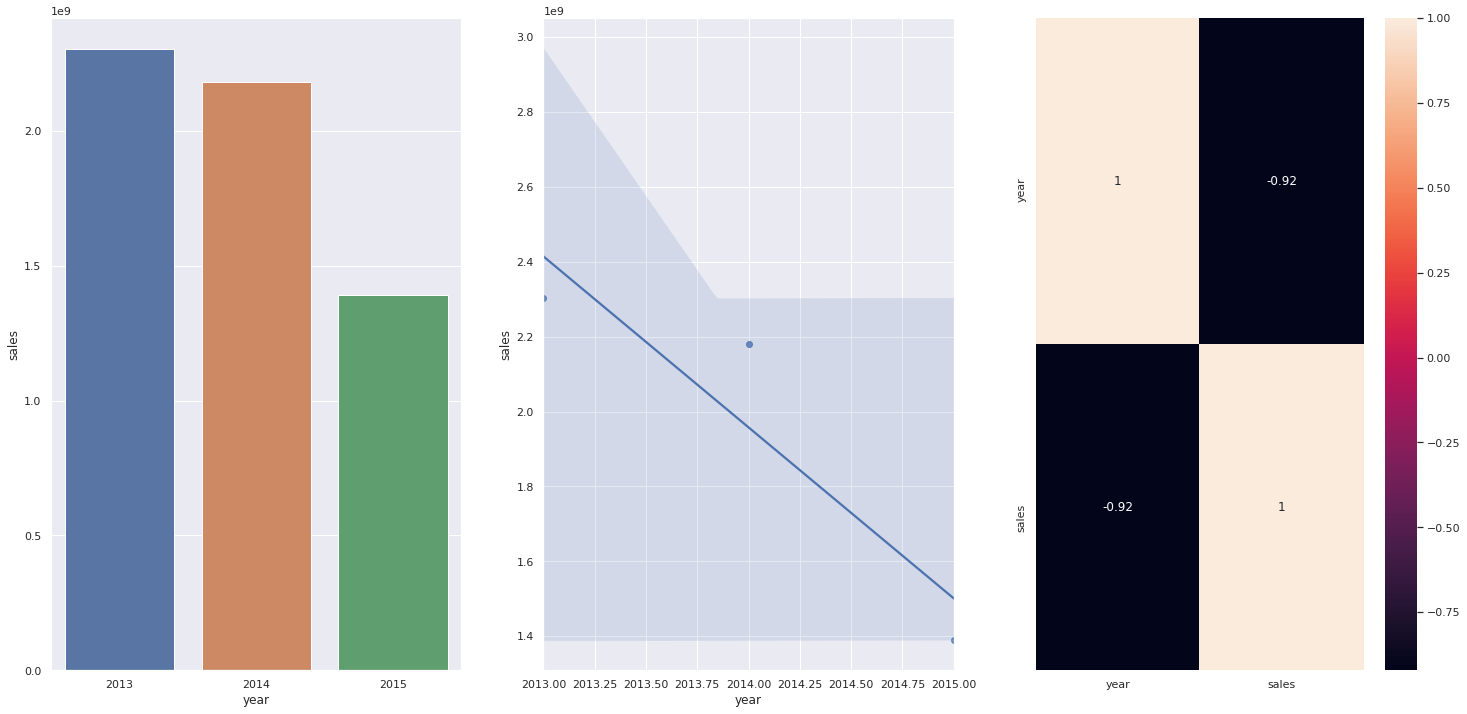

In [57]:
aux1 = df4[["year", "sales"]].groupby("year").sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="year", y="sales", data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x="year", y="sales", data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### H9. Lojas deveriam vender mais no segundo sementre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano

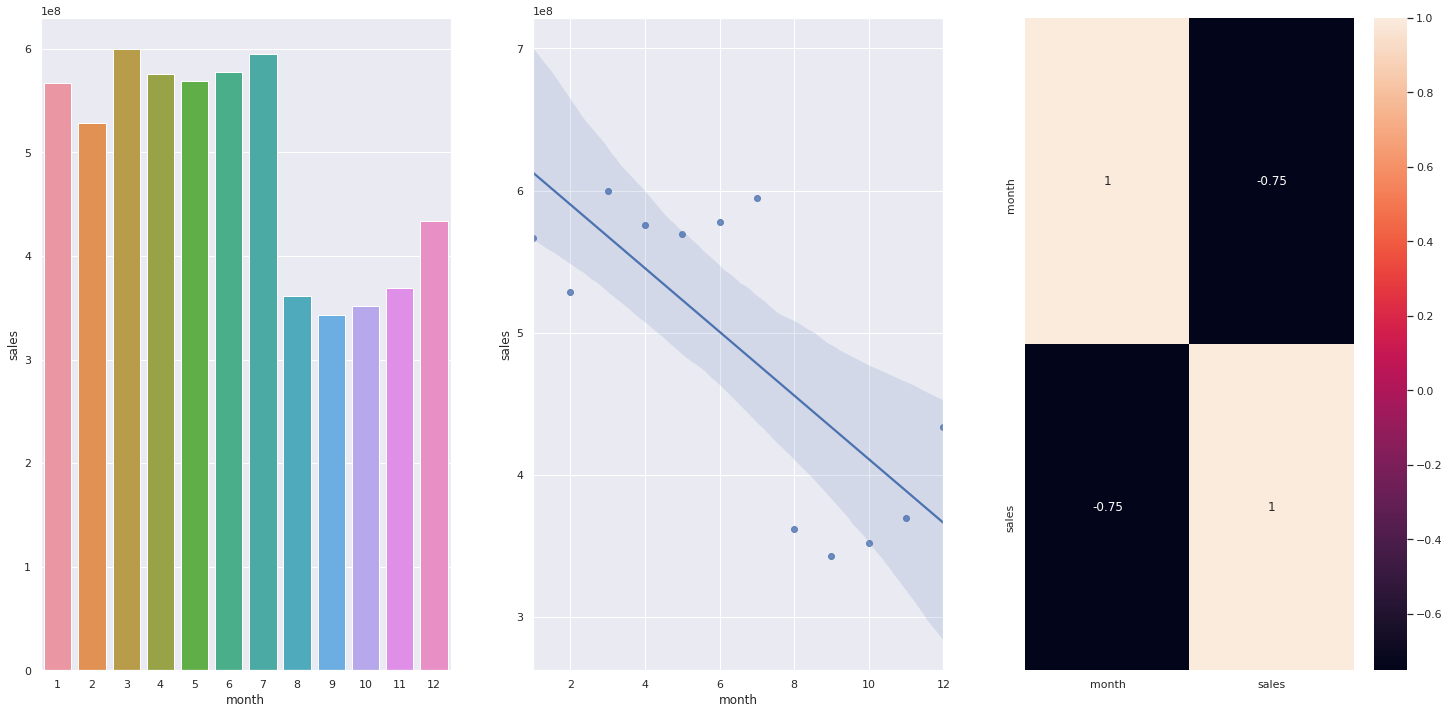

In [58]:
aux1 = df4[["month", "sales"]].groupby("month").sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="month", y="sales", data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x="month", y="sales", data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois dos 10 dia de cada mês. 

<AxesSubplot:xlabel='before_after', ylabel='sales'>

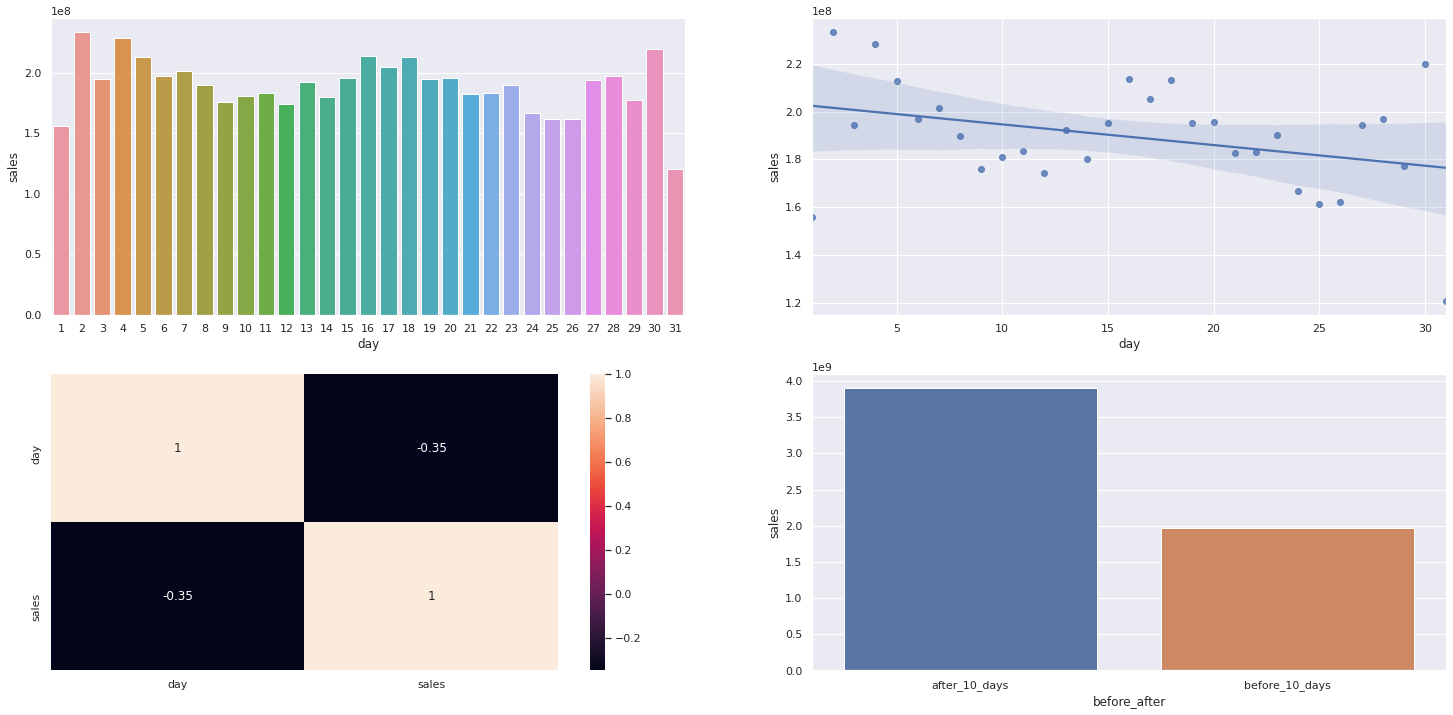

In [59]:
aux1 = df4[["day", "sales"]].groupby("day").sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x="day", y="sales", data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x="day", y="sales", data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(), annot=True);

plt.subplot(2, 2, 4)
aux1["before_after"] = aux1["day"].apply(lambda x: "before_10_days" if x <= 10 else "after_10_days")
aux2 = aux1[["before_after", "sales"]].groupby("before_after").sum().reset_index()
sns.barplot(x="before_after", y="sales", data=aux2)

### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos dos finais de semana.

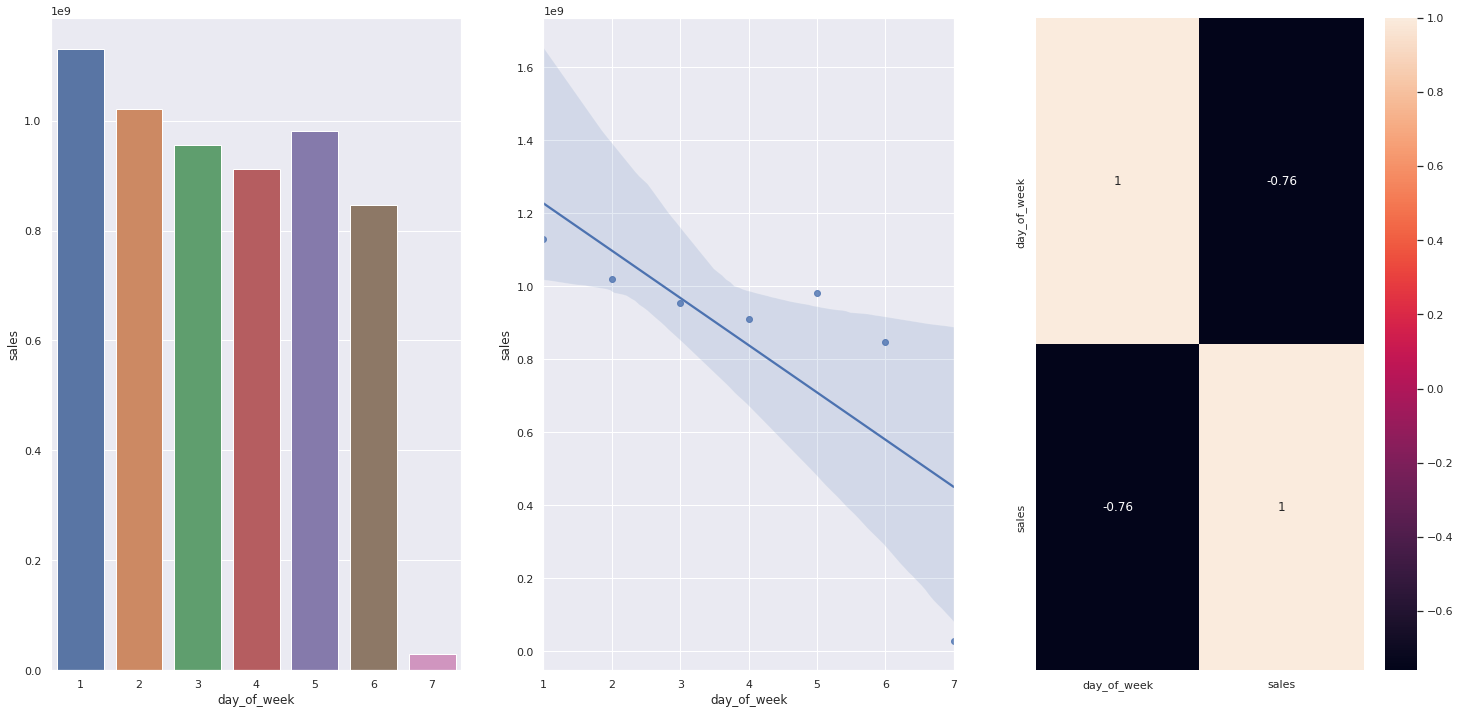

In [60]:
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="day_of_week", y="sales", data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x="day_of_week", y="sales", data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** As lojas vendem menos, porém há uma inversão no mês 7 e 8.

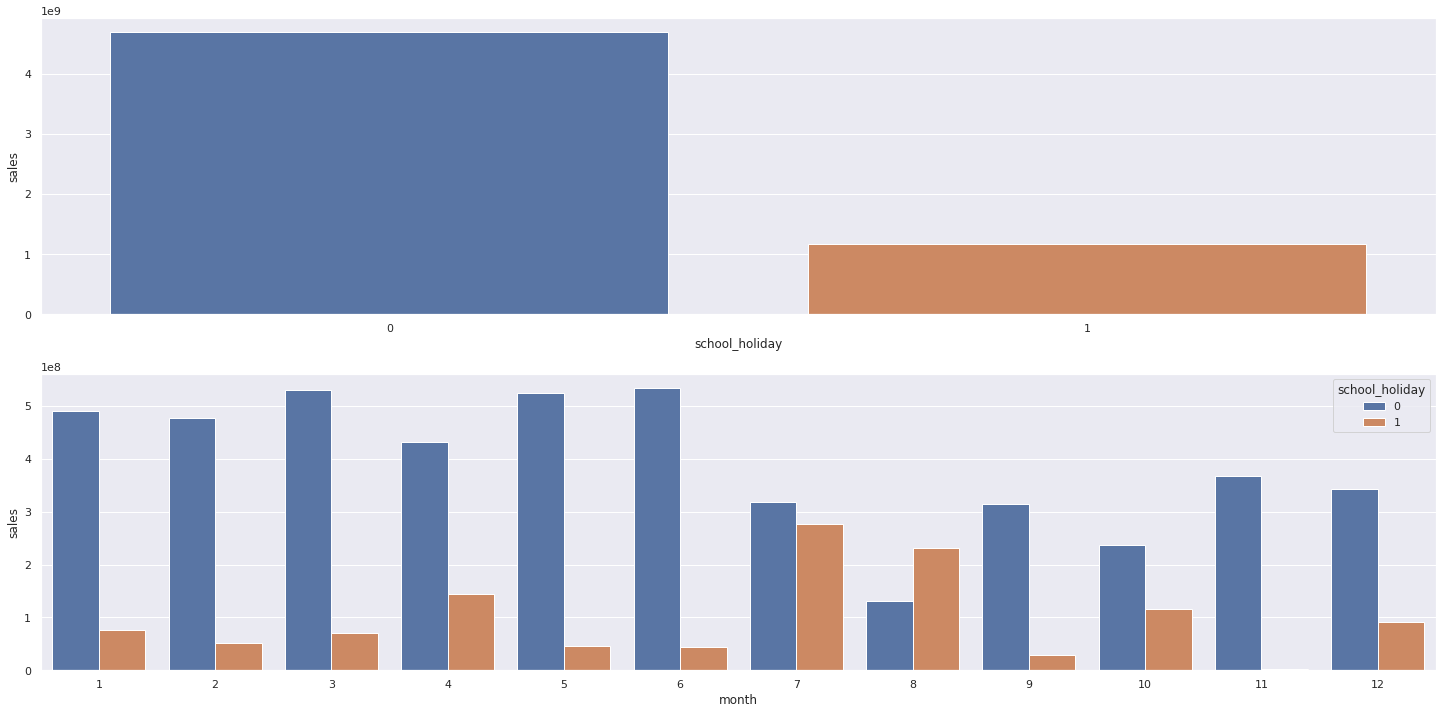

In [61]:
plt.subplot(2, 1, 1)
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").sum().reset_index()
sns.barplot(x="school_holiday", y="sales", data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[["month", "school_holiday", "sales"]].groupby(["school_holiday", "month"]).sum().reset_index()
sns.barplot(x="month", y="sales", hue="school_holiday", data=aux2);

### 4.2.1 Resumo das Hipoteses

In [62]:
from tabulate import tabulate

In [63]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],]  

print(tabulate(tab, headers='firstrow' ))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

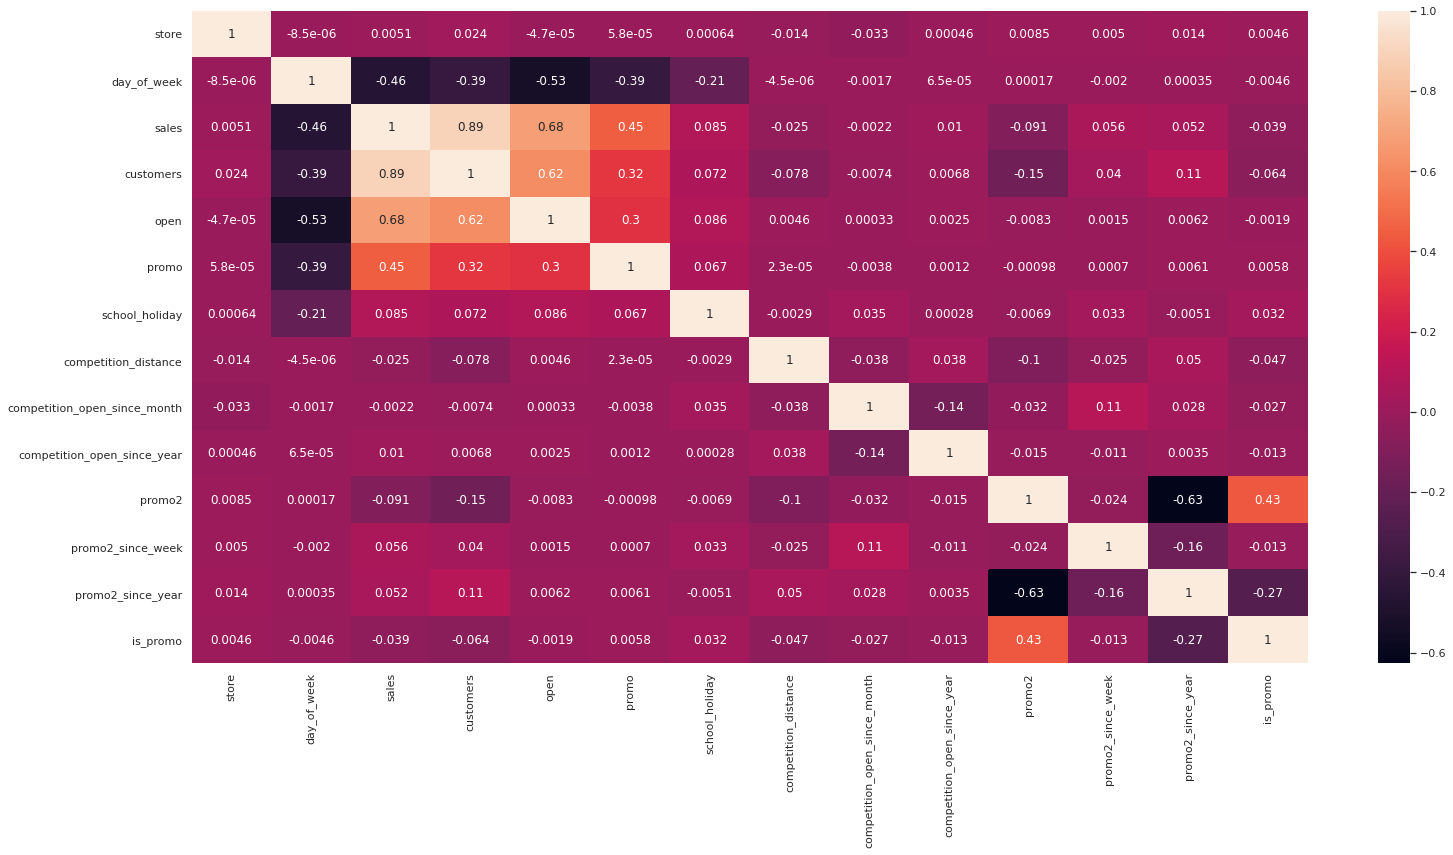

In [64]:
correlation = num_attributes.corr()
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [65]:
a = df4.select_dtypes(include="object")
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [66]:
a1 = cramer_v(a["state_holiday"], a["state_holiday"])
a2 = cramer_v(a["state_holiday"], a["store_type"])
a3 = cramer_v(a["state_holiday"], a["assortment"])

a4 = cramer_v(a["store_type"], a["state_holiday"])
a5 = cramer_v(a["store_type"], a["store_type"])
a6 = cramer_v(a["store_type"], a["assortment"])

a7 = cramer_v(a["assortment"], a["state_holiday"])
a8 = cramer_v(a["assortment"], a["store_type"])
a9 = cramer_v(a["assortment"], a["assortment"])

d = pd.DataFrame({"state_holiday": [a1, a2, a3],
              "store_type": [a4, a5, a6],
              "assortment": [a7, a8, a9],})

d = d.set_index(d.columns)

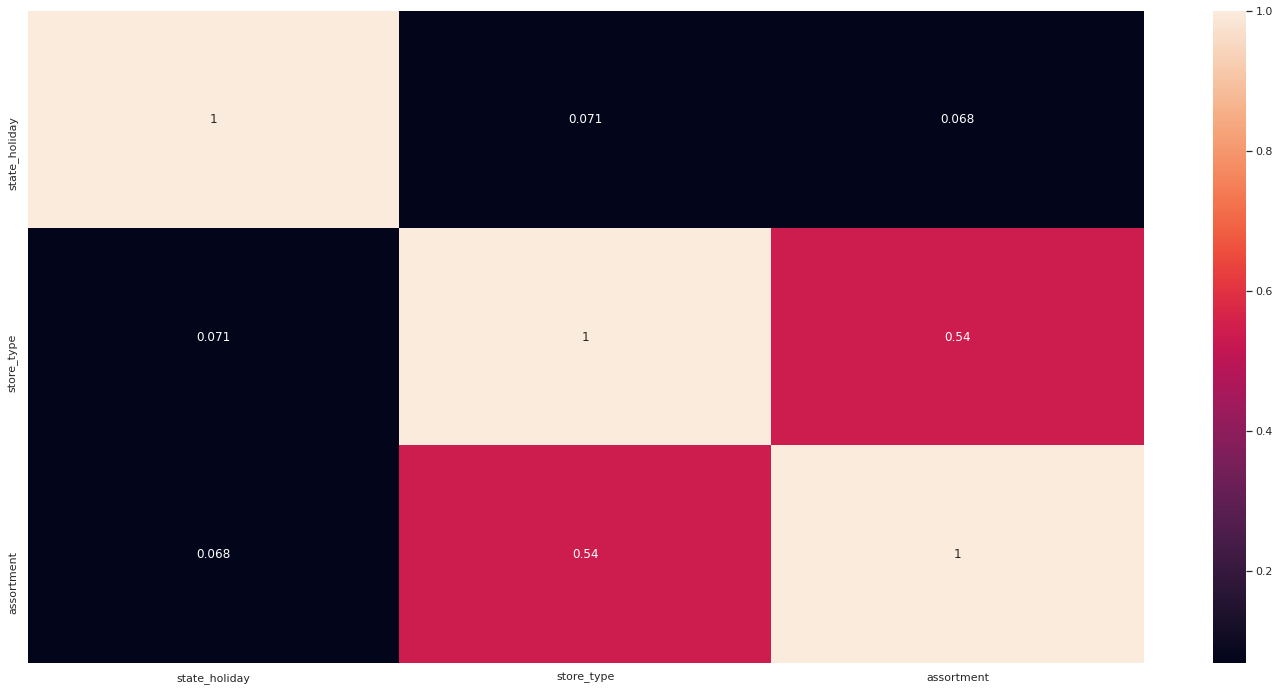

In [67]:
d = sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [124]:
df5 = df4.copy()

## 5.1 Normalização

There's no normal distribution.

## 5.2 Rescaling

In [125]:
a = df4.select_dtypes(include=["int64", "float64"])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


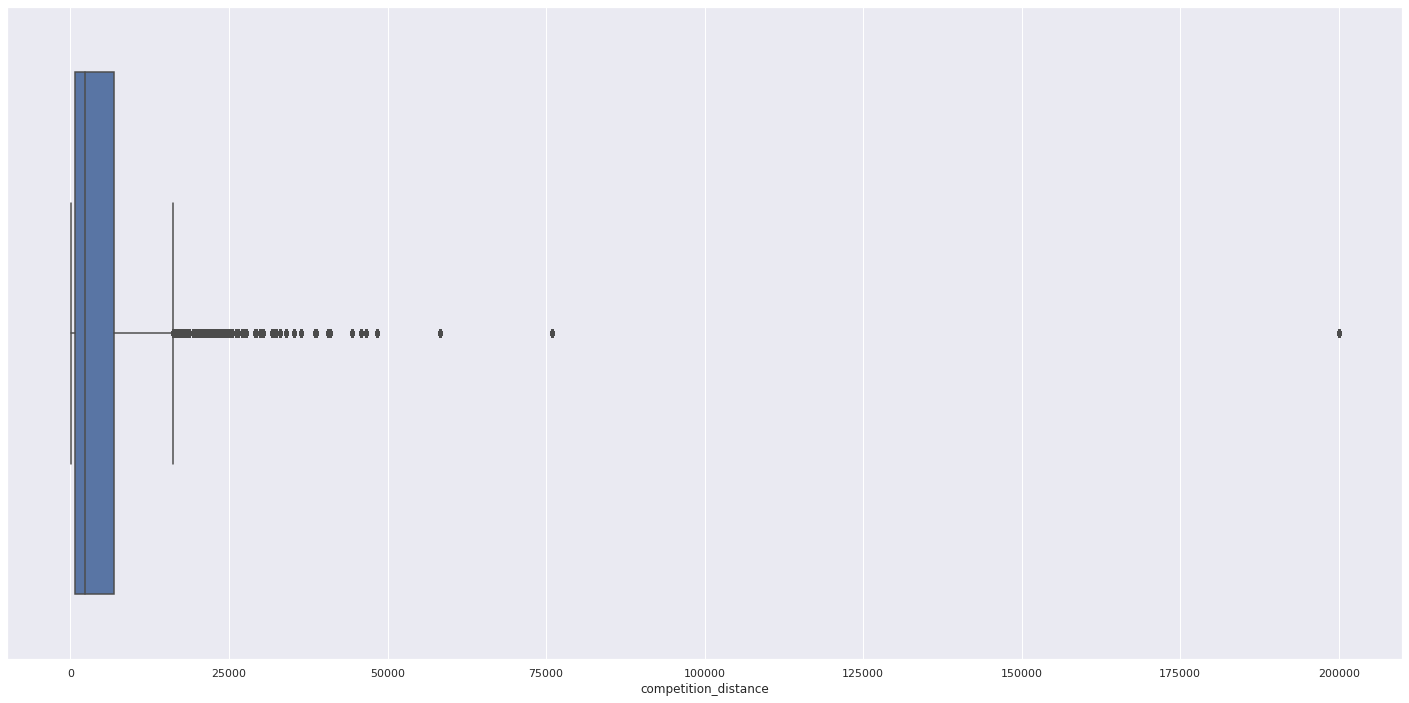

In [126]:
sns.boxplot(x="competition_distance", data=df5);

In [127]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)
dump(rs, "../parameters/competition_distance_scaler.joblib")

# year
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)
dump(mms, "../parameters/year_scaler.joblib")

# competition time month
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)
dump(rs, "../parameters/competition_time_month_scaler.joblib")

# promo time week
df5["year"] = mms.fit_transform(df5[["year"]].values)
dump(rs, "../parameters/promo_time_week_scaler.joblib")

['../parameters/promo_time_week_scaler.joblib']

## 5.3 Transformação

### 5.3.1 Encoding

In [128]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [129]:
# state_holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

# store_type - Label Enconding
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])
dump(le, "../parameters/store_type_scaler.joblib")

# assortment - Ordinal Enconding
assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
df5["assortment"] = df5["assortment"].map(assortment_dict)

In [130]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Response Variable Transformation

In [75]:
df5["sales"] = np.log1p(df5["sales"])

### 5.3.3 Nature Transformation

In [76]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day 
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [77]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selection

In [78]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [79]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [80]:
df6[["store", "date"]].groupby("store").max().reset_index()["date"][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [81]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [82]:
# # training and test dataset for botuta
# X_train_n = X_train.drop(["date", "sales"], axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomFOrestRegressor
# rf = RandomForestRegressor()

# # define boruta
# boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [83]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [84]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modeling

In [85]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [86]:
aux1 = x_test.copy()
aux1["sales"] = y_test.copy()

#prediction
aux2 = aux1[["store", "sales"]].groupby("store").mean().reset_index().rename(columns={"sales": "predictions"})
aux1 = pd.merge(aux1, aux2, how="left", on="store")

y_pred_baseline = aux1["predictions"]

#performance
baseline_result = ml_error("Average Model", np.expm1(y_test), np.expm1(y_pred_baseline))
baseline_result

,MAE,MAPE,RMSE
Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [87]:
# model
lr = LinearRegression()
lr.fit(x_train, y_train)

# prediction
y_pred_lr = lr.predict(x_test)

# perfomance
lr_result = ml_error("Linear Regression", np.expm1(y_test), np.expm1(y_pred_lr))
lr_result

,MAE,MAPE,RMSE
Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [88]:
lr_result_cv = cross_validation(x_training, 5, "Linear Regression", lr, verbose=False)
lr_result_cv

,MAE CV,MAPE CV,RMSE CV
Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model

In [89]:
# model
lrr = Lasso(alpha=0.01)
lrr.fit(x_train, y_train)

# prediction
y_pred_lrr = lrr.predict(x_test)

# perfomance
lrr_result = ml_error("Lasso", np.expm1(y_test), np.expm1(y_pred_lrr))
lrr_result

,MAE,MAPE,RMSE
Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [90]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,MAE CV,MAPE CV,RMSE CV
Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [91]:
# model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

# prediction
y_pred_rf = rf.predict(x_test)

# performance
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(y_pred_rf))
rf_result

,MAE,MAPE,RMSE
Random Forest Regressor,679.080548,0.099879,1010.101738


### 7.4.1 Random Forest Regressor - Cross Validation 

In [92]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5 XGBoost Regressor

In [93]:
# model
xgbr = XGBRegressor(objective='reg:squarederror', 
                    n_estimators=100, 
                    eta=0.01, 
                    max_depth=10, 
                    subsample=0.7,
                    colsample_bytee=0.9)

xgbr.fit(x_train, y_train)

# prediction
y_pred_xgb = xgbr.predict(x_test)

# performance
xgb_result = ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(y_pred_rf))
xgb_result

[13:58:46] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,MAE,MAPE,RMSE
XGBoost Regressor,679.080548,0.099879,1010.101738


### 7.5.1 XGBoost Regressor - Cross Validation

In [94]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgbr, verbose=True)
xgb_result_cv


KFold Number: 5
[14:03:55] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[14:07:33] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[14:11:39] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verifi

,MAE CV,MAPE CV,RMSE CV
XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 7.6 Compare Model's Performance

In [95]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values("RMSE")

,MAE,MAPE,RMSE
Random Forest Regressor,679.080548,0.099879,1010.101738
XGBoost Regressor,679.080548,0.099879,1010.101738
Average Model,1354.800353,0.455051,1835.135542
Linear Regression,1867.089774,0.292694,2671.049215
Lasso,1891.704881,0.289106,2744.451737


In [96]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values("RMSE CV")

,MAE CV,MAPE CV,RMSE CV
Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [97]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [98]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [99]:
#final_result

## 8.2 Final Model

In [100]:
param_tuned = {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 
               'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}

In [101]:
model_xgb_tuned = XGBRegressor(objective="reg:squarederror",
                               n_estimators=param_tuned["n_estimators"], 
                               eta=param_tuned["eta"], 
                               max_depth=param_tuned["max_depth"], 
                               subsample=param_tuned["subsample"],
                               colsample_bytee=param_tuned["colsample_bytree"],
                               min_child_weight=param_tuned["min_child_weight"])

In [102]:
model_xgb_tuned.fit(x_train, y_train)

[14:22:27] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytee=0.7, colsample_bytree=1,
             eta=0.03, gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0299999993,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [103]:
# prediction
y_pred_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(y_pred_xgb_tuned))
xgb_result_tuned

,MAE,MAPE,RMSE
XGBoost Regressor,760.056209,0.114528,1088.442059


In [104]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(y_pred_xgb_tuned))
mpe

-0.01954731659318828

# 9.0 Traduction and Error's Interpretation

In [105]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9["sales"] = np.expm1(df9["sales"])
df9["predictions"] = np.expm1(yhat_xgb_tuned)

<ipython-input-105-3ce4d5bc64f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9["sales"] = np.expm1(df9["sales"])
<ipython-input-105-3ce4d5bc64f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9["predictions"] = np.expm1(yhat_xgb_tuned)


In [106]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,5263.0,5677.294922
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,6064.0,6056.549805
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,8314.0,10086.269531
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,13995.0,11783.937500
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,4822.0,6054.158691


## 9.1 Business Performance

In [107]:
# sum of predictions
df91 = df9[["store", "predictions"]].groupby("store").sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[["store", "sales", "predictions"]].groupby("store").apply(lambda x: mean_absolute_error(x["sales"], x["predictions"]) ).reset_index().rename(columns={0: "MAE"})

df9_aux2 = df9[["store", "sales", "predictions"]].groupby("store").apply(lambda x: mean_absolute_percentage_error(x["sales"], x["predictions"] ) ).reset_index().rename( columns={0: "MAPE"})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how="inner", on="store")
df92 = pd.merge(df91, df9_aux3, how="inner", on="store")

# Scenarios
df92["worst_scenario"] = df92["predictions"] - df92["MAE"]
df92["best_scenario"] = df92["predictions"] + df92["MAE"]

# order columns
df92 = df92[["store", "predictions", "worst_scenario", "best_scenario", "MAE", "MAPE"]]

In [108]:
df92.sort_values("MAPE", ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106847.437500,103487.570531,110207.304469,3359.866969,0.588682
908,909,228641.281250,220905.432002,236377.130498,7735.849248,0.515674
169,170,207574.890625,206071.569296,209078.211954,1503.321329,0.372452
875,876,202657.421875,198713.397769,206601.445981,3944.024106,0.317062
594,595,370526.312500,366237.483121,374815.141879,4288.829379,0.295611


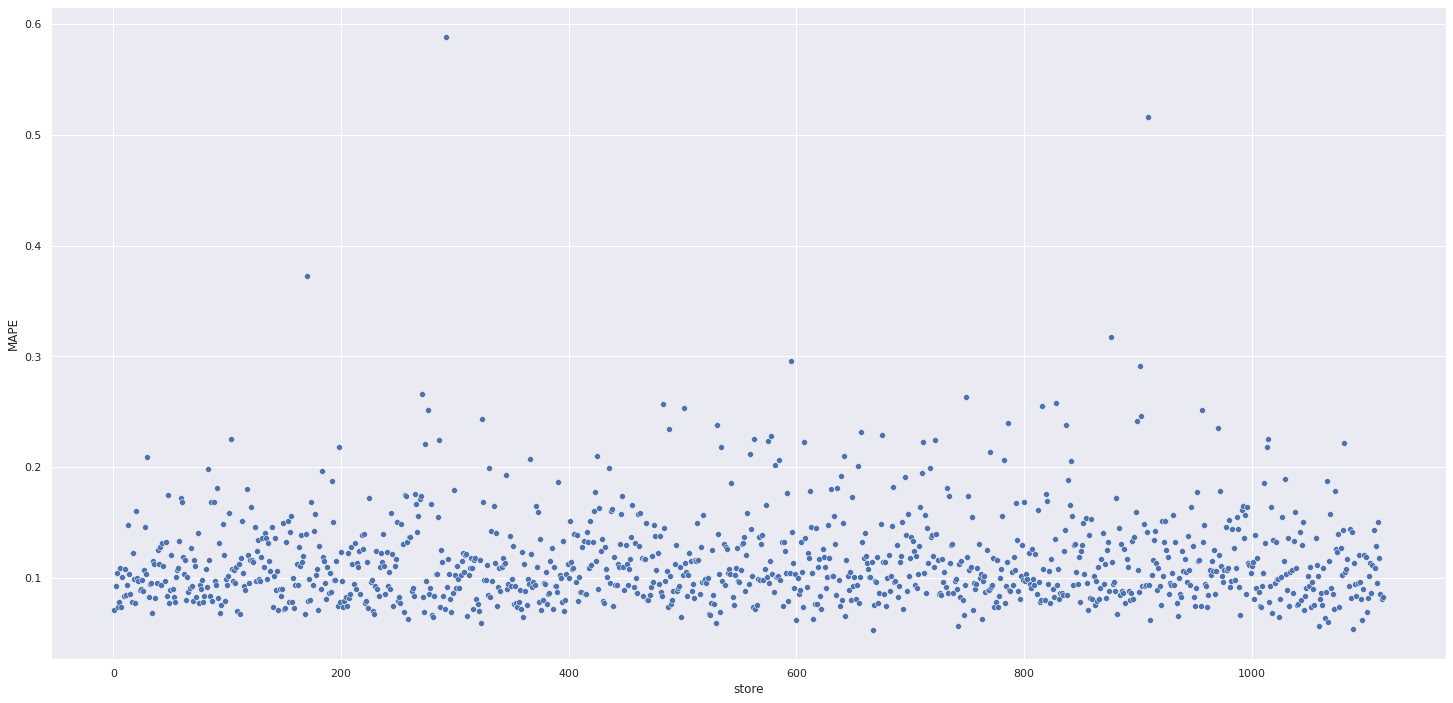

In [109]:
sns.scatterplot(x="store", y="MAPE", data=df92);

## 9.2 Total Performance

In [110]:
df93 = df92[["predictions", "worst_scenario", "best_scenario"]].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={"index": "Scenario", 0: "Values"})

df93["Values"] = df93["Values"].map("R${:,.2f}".format)
df93

,Scenario,Values
0,predictions,"R$287,261,344.00"
1,worst_scenario,"R$286,410,600.30"
2,best_scenario,"R$288,112,076.87"


## 9.1 Machine Learning Performance

In [111]:
df9["error"] = df9["sales"] - df9["predictions"]
df9["error_rate"] = df9["predictions"] / df9["sales"]

<ipython-input-111-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-111-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

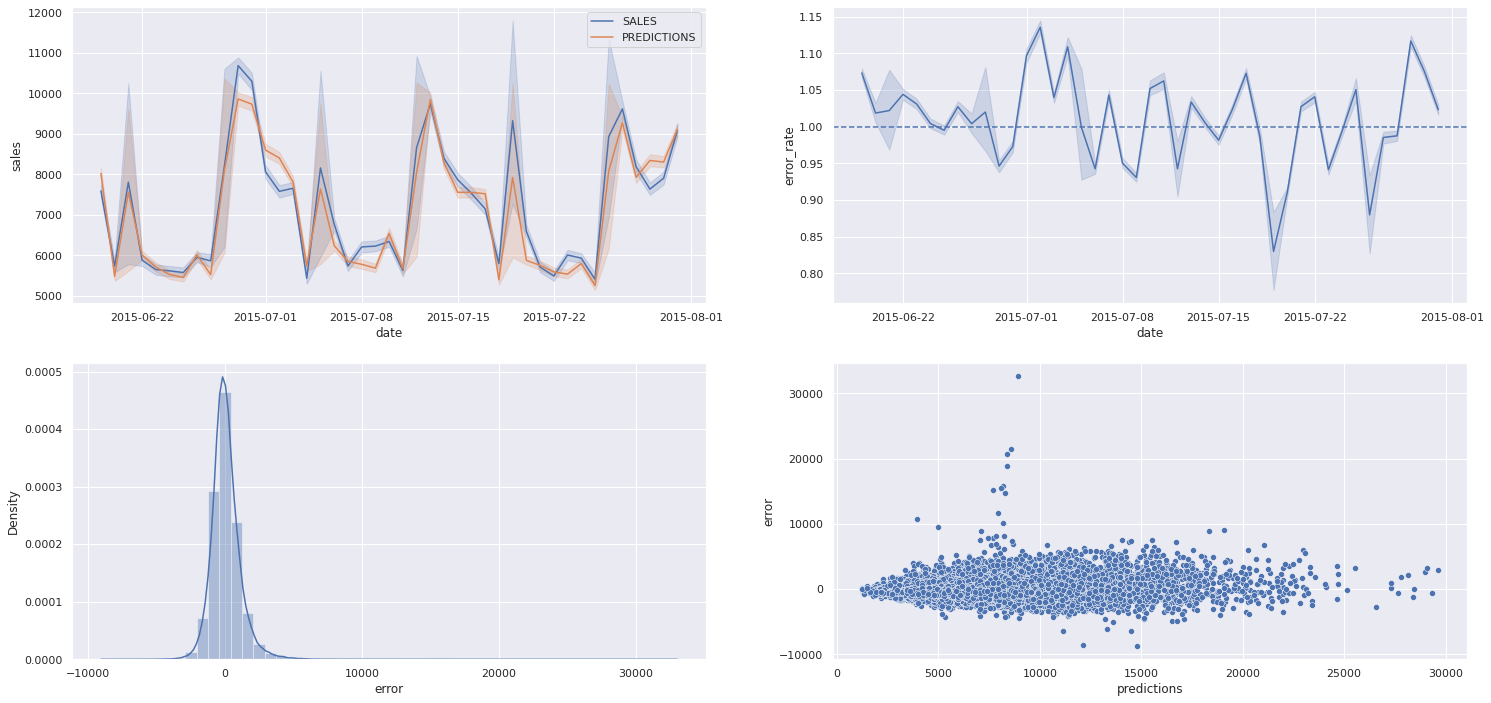

In [112]:
plt.subplot(2, 2, 1)
sns.lineplot(x="date", y="sales", data=df9, label="SALES")
sns.lineplot(x="date", y="predictions", data=df9, label="PREDICTIONS")

plt.subplot(2, 2, 2)
sns.lineplot(x="date", y="error_rate", data=df9)
plt.axhline(1, linestyle="--")

plt.subplot(2, 2, 3)
sns.distplot(df9["error"])

plt.subplot(2, 2, 4)
sns.scatterplot(df9["predictions"], df9["error"])

# 10.0 Deploy Model Prediction

In [120]:
# Save Trained Model
dump(model_xgb_tuned, "../models/model_rossmann.joblib")

['model_rossmann.joblib']

## 10.1 Rossman Class

In [114]:
import inflection
import pandas as pd
import numpy as np
import math
import datetime
from joblib import load

class Rossmann(object):
    
    def __init__(self):
        
        self.competition_distance_scaler   = load("../parameters/competition_distance_scaler.joblib")
        self.competition_time_month_scaler = load("../parameters/competition_time_month_scaler.joblib")
        self.promo_time_week_scaler        = load("../parameters/promo_time_week_scaler.joblib")
        self.year_scaler                   = load("../parameters/year_scaler.joblib")
        self.store_type_scaler             = load("../parameters/store_type_scaler.joblib")
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [115]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = load("../models/model_rossmann.joblib")

# initialize API
app = Flask( __name__ )

@app.route("/rossmann/predict", methods=["POST"])
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [132]:
# loading test dataset
df10 = pd.read_csv("../databases/test.csv")

In [133]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how="left", on="Store")

# choose store for prediction
df_test = df_test[df_test["Store"].isin([20, 23, 22])]

# remove closed days
df_test = df_test[df_test["Open"] != 0]
df_test = df_test[~df_test["Open"].isnull()]
df_test = df_test.drop("Id", axis=1)

In [134]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient="records"))

In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = "https://rossmann-model-test.herokuapp.com/rossmann/predict"
header = {"Content-type': 'application/json"} 
data = data

r = requests.post( url, data=data, headers=header )
print("Status Code {}".format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[["store", "prediction"]].groupby("store").sum().reset_index()

for i in range( len( d2 ) ):
    print("Store Number {} will sell R${:,.2f} in the next 6 weeks".format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction']))